In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine import connectivity
from quetzal.io import excel
if manual: import matplotlib.pyplot as plt

# Preparation of the transport network.
## Initialises a StepModel with parametrised zones.

In [3]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Initialising StepModel...
sm = stepmodel.StepModel(debug=False,
                         walk_on_road=False,
                         epsg=4326,
                         coordinates_unit=None)

Model zones are official administrative areas of Germany called "Gemeindeverbände". Geo-data is published under "Open Data Datenlizenz Deutschland – Namensnennung – Version 2.0"

Data source is: https://gdz.bkg.bund.de/index.php/default/digitale-geodaten/verwaltungsgebiete/verwaltungsgebiete-1-250-000-ebenen-stand-01-01-vg250-ebenen-01-01.html

© GeoBasis-DE / BKG 2022

In [6]:
# Loading zones at level of "Gemeindeverband"
zones = gpd.read_file(input_path + 'administrative_zones_shapes/VG250_VWG.shp')
# Drop water areas and unused columns
zones = zones.loc[zones['GF']==4, ['ARS', 'NUTS', 'GEN', 'geometry']]
len(zones)

4605

In [7]:
# Update ARS codes to June 2022
zones.loc[zones['ARS']=='160560000', 'ARS'] = '160630105' # Eisenach
zones.loc[zones['ARS']=='031530007', 'ARS'] = '031530019' # Langelsheim
zones.loc[zones['ARS']=='032565405', 'ARS'] = '032565411' # Liebenau, Marklohe
zones.loc[zones['ARS']=='032565406', 'ARS'] = '032565412' # Liebenau, Marklohe
zones.loc[zones['ARS']=='120730532', 'ARS'] = '120735051' # Schwedt/Oder
# Bastheim is part of Mellrichstadt
zones.loc[zones['ARS']=='096730116', 'ARS'] = '096735633'
zones.loc[zones['ARS']=='096735633', 'geometry'] = zones.loc[zones['ARS']=='096735633', 'geometry'].unary_union
zones = zones.loc[zones['GEN']!='Bastheim']
# Neuhardenberg is part of Seelow-Land
zones.loc[zones['ARS']=='120645410', 'ARS'] = '120645412'
zones.loc[zones['ARS']=='120645412', 'geometry'] = zones.loc[zones['ARS']=='120645412', 'geometry'].unary_union
zones = zones.loc[zones['GEN']!='Neuhardenberg']

In [8]:
# Add them to the model
sm.zones = zones
sm.zones.columns = ['ARS', 'NUTS_ID', 'name', 'geometry']
sm.zones['ARS'] = sm.zones['ARS'].astype(int)
sm.zones.set_index('ARS', drop=False, inplace=True)
sm.zones.index.name = None
sm.zones.sample()

,ARS,NUTS_ID,name,geometry
72355004,72355004,DEB25,Ruwer,"POLYGON ((3338578.281 5518542.530, 3338629.693..."


In [9]:
# Set the CRS to the model CRS
sm.zones = sm.zones.to_crs(epsg=4326)

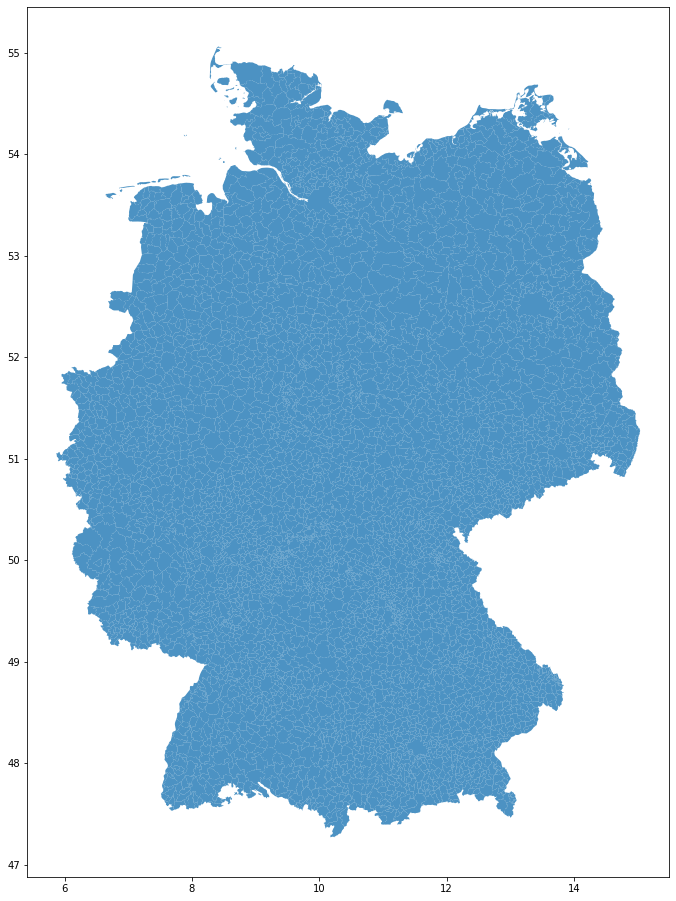

In [10]:
if manual:
    sm.zones.plot(alpha=.8, figsize=(16,16))

### Get zone data

Data for administrative zones in Germany is published under "Open Data Datenlizenz Deutschland – Namensnennung – Version 2.0"

Data source is: https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/_inhalt.html

© GeoBasis-DE / BKG 2022

In [11]:
# Load
col_names =['level_code', 'type_code', 'ARS_Land', 'ARS_RB', 'ARS_Kreis',
            'ARS_VB', 'ARS_Gem', 'name', 'area', 'date', 'population',
            'pop_male', 'pop_female', 'pop_density', 'zip_code', 'lat',
            'lon', 'travel_area_key', 'travel_area_name',
            'urbanisation_key', 'urbanisation_name']
zone_data = pd.read_excel(input_path + 'zone_data.xlsx', sheet_name='Onlineprodukt_Gemeinden',
                          decimal=',', thousands=' ', header=5, skipfooter=12,
                          names=col_names, na_filter=False)

In [12]:
# Drop "Kreis"-level and outer-German zones
zone_data = zone_data.loc[(zone_data['ARS_VB']!='') & (zone_data['ARS_VB']!='9999')]
len(zone_data)

15590

In [13]:
# Create FID
zone_data['ARS'] = (zone_data['ARS_Land'].astype(str) + zone_data['ARS_RB']
                    + zone_data['ARS_Kreis'] + zone_data['ARS_VB']).astype(int)

In [14]:
# Fill values at "Gemeindeverbands"-level
cols = ['area', 'population', 'zip_code', 'lat', 'lon', 'urbanisation_key']
types = [np.float64, np.int64, str, np.float64, np.float64, np.int64]
zone_data = zone_data.loc[zone_data['ARS_Gem']!='', cols+['ARS']
                         ].astype(dict(zip(cols, types))).groupby('ARS').agg({
    'area': 'sum',
    'population': 'sum',
    'zip_code': tuple,
    'lat': 'mean',
    'lon': 'mean',
    'urbanisation_key': 'mean'
})
len(zone_data)

4600

In [15]:
zone_data.rename(columns={'urbanisation_key':'urbanisation'}, inplace=True)
zone_data['urbanisation'] = zone_data['urbanisation'].apply(lambda u: int(u)).astype(int)
zone_data.sample()

,area,population,zip_code,lat,lon,urbanisation
ARS,,,,,,
81175010,31.29,18876,"(73095, 73066)",9.575024,48.698841,2


In [16]:
len(zone_data.loc[zone_data['population']==0])

204

In [17]:
# Add attributes to zones table
for col in zone_data.columns:
    sm.zones[col] = sm.zones['ARS'].map(zone_data[col])
# Fill default values for missing zones
sm.zones.loc[sm.zones['area'].isna(), 'area'] = 0
sm.zones.loc[sm.zones['population'].isna(), 'population'] = 0
sm.zones.loc[sm.zones['zip_code'].isna(), 'zip_code'] = [
    (0,) for _ in range(len(sm.zones.loc[sm.zones['zip_code'].isna()]))]
sm.zones.loc[sm.zones['lat'].isna(), 'lat'] = [
    g.centroid.coords[0][0] for g in sm.zones.loc[sm.zones['lat'].isna(), 'geometry']]
sm.zones.loc[sm.zones['lon'].isna(), 'lon'] = [
    g.centroid.coords[0][1] for g in sm.zones.loc[sm.zones['lon'].isna(), 'geometry']]
sm.zones.loc[sm.zones['urbanisation'].isna(), 'urbanisation'] = 3
sm.zones.loc[sm.zones.isna().any(axis=1)]

,ARS,NUTS_ID,name,geometry,area,population,zip_code,lat,lon,urbanisation


<AxesSubplot:>

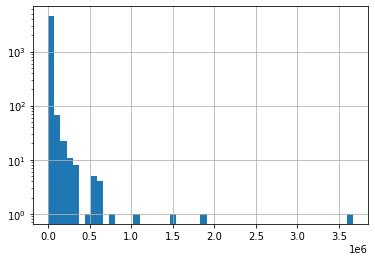

In [18]:
sm.zones['population'].hist(bins=50, log=True)

<AxesSubplot:>

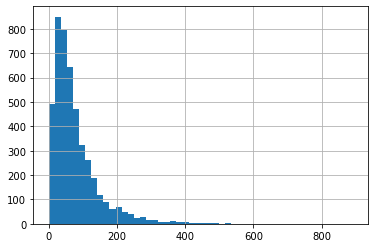

In [19]:
sm.zones['area'].hist(bins=50)

### Cluster zones

Use agglomerative clustering in order to reduce the number of small zones

In [20]:
# Use quetzal's node clustering function
# Cluster zones only within NUTS3-zones
if params['zones']['radius_share'] > 0:
    dist_col = 'dist'
    nuts_zones = gpd.GeoSeries(sm.zones.groupby('NUTS_ID').apply(lambda g: g['geometry'].unary_union.buffer(1e-3)))
    cluster_zones = gpd.GeoDataFrame(data={dist_col: nuts_zones.area ** 0.5 * params['zones']['radius_share']},
                                     index=nuts_zones.index,
                                     geometry=list(nuts_zones))
    clustered = connectivity.adaptive_clustering(nodes=gpd.GeoDataFrame(sm.zones[['ARS']],
                                                            geometry=sm.zones.centroid),
                                                 zones=cluster_zones,
                                                 distance_col=dist_col)
    # Number of zones
    print(len(clustered['adaptive_cluster_id'].unique()))
    # Aggregate zone data
    sm.zones['cluster_id'] = list(clustered['adaptive_cluster_id'])
    sm.zones = gpd.GeoDataFrame(sm.zones.groupby('cluster_id').agg({
        'NUTS_ID': 'first',
        'ARS': tuple,
        'name': tuple,
        'area': 'sum',
        'population': 'sum',
        'lat': 'mean',
        'lon': 'mean',
        'urbanisation': 'mean',
        'geometry': lambda g: g.unary_union
    }))
    # Merge Sylt to one zone
    sylt = sm.zones.loc[sm.zones['name'].apply(lambda l: sum(['Sylt' in s for s in l])>0)]
    to_drop = sylt.index
    sm.zones.loc['DEF07_99'] = {'NUTS_ID': 'DEF07', 'ARS': sylt['ARS'].sum(),
                                'name': ('Sylt',), 'area': sylt['area'].sum(),
                                'population': sylt['population'].sum(),
                                'lat': 8.308750, 'lon': 54.907860, 'urbanisation': 2,
                                'geometry': sylt['geometry'].unary_union,
                                'pop_share': sylt['population'].sum() / sm.zones.loc[
                                    sm.zones['NUTS_ID']=='DEF07', 'population'].sum(),
                                'FID': 'DEF07_99'}
    sm.zones.drop(to_drop, inplace=True)

In [21]:
# Manage attributes
sm.zones['urbanisation'] = sm.zones['urbanisation'].astype(int)
sm.zones['population'] = sm.zones['population'].astype(int)
sm.zones['pop_share'] = sm.zones['population'] / sm.zones['NUTS_ID'].map(
    sm.zones.groupby('NUTS_ID')['population'].sum())
sm.zones['FID'] = sm.zones.index
sm.zones.head(3)

,ARS,NUTS_ID,name,geometry,area,population,zip_code,lat,lon,urbanisation,pop_share,FID
10010000,10010000,DEF01,Flensburg,"POLYGON ((9.41266 54.82264, 9.41318 54.82124, ...",56.73,89934,"(24937,)",9.437510,54.782520,1,1.0,10010000
10020000,10020000,DEF02,Kiel,"POLYGON ((10.16916 54.43138, 10.16957 54.43067...",118.65,246601,"(24103,)",10.137270,54.321775,1,1.0,10020000
10030000,10030000,DEF03,Lübeck,"POLYGON ((10.87684 53.98737, 10.87884 53.98595...",214.19,215846,"(23539,)",10.683932,53.866269,1,1.0,10030000


In [24]:
len(zones)

4603

In [25]:
# Correct north sea islands
# Delete islands without population
sm.zones = sm.zones.loc[~(sm.zones['name'].apply(lambda l: 'Insel Lütje Hörn' in l))]
len(sm.zones)

4602

### Correct population to future

Using NUTS3-level data from the "BBSR Raumordnungsprognose 2040" with constant inner-zonal population shares

In [26]:
if params['general']['year'] > 2022:
    pop = pd.read_excel(input_path + "population_2040.xlsx",
                        sheet_name='Bev_Krs_g_17-40', usecols=list(range(8)), skiprows=3)
    year = min(int(5 * round(params['general']['year'] / 5)), 2040)
    pop['lau_id'] = pop['Krs'].apply(lambda i: int(str(i)[:-3]))
    pop = pop.set_index('lau_id')[year]
    sm.zones['population'] = sm.zones['FID'].apply(lambda i: int(str(i)[:-4])
                                                  ).map(pop) * sm.zones['pop_share']
    assert not sm.zones['population'].isna().max()

### Add car ownership

In [28]:
# Get exogenous car availability in household by urbanisation degree
sm.zones['car_avail_hh'] = sm.zones['urbanisation'].map(params['car_avail_hh'].to_dict())

### Add employment and workforce

Employment data is available from the German Federal job agency for 2017. This data source is valid in coverage, but does not account all jobs that are available (only 600 thousand): https://statistik.arbeitsagentur.de/DE/Navigation/Statistiken/Fachstatistiken/Gemeldete-Arbeitsstellen/Gemeldete-Arbeitsstellen-Nav.html

The LOCALISED project's data sharing platform client also has disaggregated data on LAU level, but it's certainly not valid (as of Sep. 2024): https://github.com/FZJ-IEK3-VSA/LOCALISED-Datasharing-API-Client

Employment data from Eurostat dataset NAMA_10R_3EMPERS for the year 2017 at NUTS3-level is used.

The workforce must be calculated from age groups and unemployment shares. Unemployment shares come from Eurostat dataset tgs00010 on NUTS2-level. Age groups come from the GENESIS database on LAU level.

In [7]:
# Load employed persons data
employment = pd.read_csv(input_path + 'employed_persons_2017_eurostat.csv', encoding='latin-1')
employment['Value'] = (pd.to_numeric(employment['Value'].str.replace(',', '')) * 1000).astype(int)
# Also, load NUTS-names
nuts = gpd.read_file(input_path + "NUTS_RG_01M_2016_4326.geojson")
nuts = nuts[(nuts["CNTR_CODE"]=="DE") & (nuts["LEVL_CODE"]==3)]
# Map differing names of zones to names in employment data
name_dict = {'Burgenlandkreis (DE)': 'Burgenlandkreis',
             'Dillingen an der Donau': 'Dillingen a.d. Donau',
             'Mühldorf am Inn': 'Mühldorf a. Inn',
             'Neumarkt in der Oberpfalz': 'Neumarkt i. d. OPf.',
             'Neustadt an der Aisch-Bad Windsheim': 'Neustadt a. d. Aisch-Bad Windsheim',
             'Neustadt an der Waldnaab': 'Neustadt a. d. Waldnaab',
             'Pfaffenhofen an der Ilm': 'Pfaffenhofen a. d. Ilm',
             'Weiden in der Oberpfalz, Kreisfreie Stadt': 'Weiden i. d. Opf, Kreisfreie Stadt',
             'Wunsiedel im Fichtelgebirge': 'Wunsiedel i. Fichtelgebirge'}
employment['GEO'].replace(name_dict, inplace=True)
zone_dict = employment.set_index('GEO')['Value'].to_dict()
name_dict = nuts.set_index('NUTS_ID')['NUTS_NAME'].to_dict()
sm.zones['employment'] = sm.zones['NUTS_ID'].map(name_dict).map(zone_dict) * sm.zones['pop_share']
# Apply changes in future
sm.zones['employment'] = sm.zones['employment'] * sm.zones['urbanisation'].map(params['employment_change'])
assert not sm.zones['employment'].isna().max()
sm.zones['employment'] = sm.zones['employment'].astype(float)
sm.zones['employment'].sum() / 1e6

In [26]:
# Add workforce data
# Load input data
unemployment = pd.read_csv(input_path + 'unemployment_rate_NUTS2.csv', index_col=0)
age_groups = pd.read_csv(input_path + 'Zensus_ages_2017_GENESIS.csv',
                         encoding='latin-1', sep=';', skiprows=5, skipfooter=4, na_values='-').dropna()
age_groups.rename(columns={'Unnamed: 1': 'lau_id'}, inplace=True)
age_groups.loc[age_groups['lau_id']==16056, 'lau_id'] = 16063 # Update Eisenach
age_groups = age_groups.groupby('lau_id').sum()
working_age = age_groups.loc[:, '18 bis unter 20 Jahre' : '60 bis unter 65 Jahre'].sum(axis=1)
sm.zones['lau_id'] = (sm.zones['FID'].astype(str).str[:-4]).astype(int)
# calculate
sm.zones['employed'] = \
    sm.zones['pop_share'] * sm.zones['lau_id'].map(working_age) \
    * (1 - sm.zones['NUTS_ID'].str[:4].map(unemployment[unemployment.columns[0]])/100)
del sm.zones['lau_id']
# Apply changes in future
sm.zones['employed'] = sm.zones['employed'] * sm.zones['urbanisation'].map(params['employed_change'])
assert not sm.zones['employed'].isna().max()
sm.zones['employed'] = sm.zones['employed'].astype(float)
sm.zones['employed'].sum() / 1e6

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_9576\3622545754.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  age_groups = pd.read_csv(input_path + 'Zensus_ages_2017_GENESIS.csv',


49.693403163999996

## Save model

In [38]:
import os
if not os.path.exists(model_path + scenario + '/'):
    os.makedirs(model_path + scenario + '/')

In [27]:
# Saving model zones as geojson
sm.to_json(model_path + scenario + '/' + 'de_zones',
           only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|███████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.14it/s]
